camera calibration

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import logging
%matplotlib inline

# Logging

In [ ]:
import logging, sys


def init_logging():
    
    #--- refs: code taken from: https://docs.python.org/3/howto/logging-cookbook.html
    #--- https://stackoverflow.com/a/9321890
    #--- https://stackoverflow.com/a/56366848   to clear any existing loggers
    
    
    for handler in logging.root.handlers[:]:
        logging.root.removeHandler(handler)
    
    logger = logging.getLogger()

    logging.basicConfig(
        level    = logging.DEBUG, 
        format   = '%(asctime)s | %(levelname)-8s | %(name)s: %(message)s',
        filename = 'adv_lane_find.log',
        filemode = 'w'
    )
        
    #--- console: INFO only, abbreviated format
    console = logging.StreamHandler(sys.stdout)
    console.setLevel(logging.INFO)
    console_formatter = logging.Formatter('%(levelname)-8s | %(name)s: %(message)s')
    console.setFormatter(console_formatter)
    logger.addHandler(console)
    
    return

# Camera Module
- ChessoardImage
- ChessboardCameraCalibrationSet
- Camera

In [ ]:
class ChessboardImage:
    '''
    An image of a chessboard used to calibrate Camera
    
    Methods:
    - __init__: specify base, filename, and inner square dims of chessboad image
    - findChessboardCorners
    
    Notes:
    - the objpoints and imgpoints are used to calibrate camera
    - img_corners can be used to display the image to verify that corners were found correctly
    '''
    
    def __init__ (self, base_path, filename, inner_dims):
        logger = logging.getLogger ("ChessboardImage")
        
        #--- RGB image of chessboard
        self.img = mpimg.imread(base_path + filename)
        self.filename = filename
        
        #---inner dimensions of chessboard
        self.xdim, self.ydim = inner_dims

        #--- object and image points used in findChessboardCorners()
        self.objpoints = None
        self.imgpoints = None
        
        #--- image of chessboard annotated with corners found
        self.img_corners = None
        
        msg = 'Image loaded for {} with dims {}.'
        self.logger.debug (msg.format(self.filename, (self.xdim, self.ydim)))
        
        return
    
    def findChessboardCorners(self):
        '''
        Finds the chessboard corners of the chessboard image
        
        Returns:
        - corners_found: the image space coordinates of the corners of the chessboard image
        
        '''
        
        #--- given the chessboard image and inner dimensions (xdim, ydim), find the chessboard corners 
        gray = cv2.cvtColor(self.img, cv2.COLOR_RGB2GRAY)
        corners_found, corners = cv2.findChessboardCorners(gray, (self.xdim, self.ydim), flags=None)
        
        if corners_found:
            #--- generate object points in the XY plane; Z=0
            #--- dimensions will be based on the chessboard_images
            #--- corners found are placed in an order from left to right, top to bottom
            #--- thereforem object points are generated in column (X) priority order
            #--- ref: https://docs.opencv.org/master/dc/dbb/tutorial_py_calibration.html
            #--- object_points should be: (0,0,0), (1,0,0), (2,0,0)..(xdim-1,0,0), (1,1,0)...
            self.objpoints = np.zeros(shape=(self.xdim * self.ydim, 3), dtype=np.float32)
            self.objpoints[:, :2] = np.array([(x, y) for y in range(self.ydim) for x in range(self.xdim)])
            
            #--- save corners found to imgpoints
            self.imgpoints = corners
            
            #--- save image with corners annotated to img_corners
            self.img_corners = np.copy (self.img)
            self.img_corners = cv2.drawChessboardCorners(self.img_corners, (self.xdim, self.ydim), self.imgpoints, True)                 
            
            msg = "Found corners for {}."
            self.logger.debug (msg.format(self.filename))
        else:

            msg = "DID NOT FIND corners for {}, dims: {}."
            self.logger.warning (msg.format(self.filename, (self.xdims, self.ydims)))
            
        return corners_found
    
    
class ChessboardCameraCalibrationSet:
    '''
    Distortion calibration set for Camera
    
    Methods:
    - __init__: specifies path, filenames and inner square dimensions chessboard images
    - loadChessboardImages
    - findChessboardCorners
    - showCorners
    - getCalibrationParams
    - getChessboardImg
    '''
    
    def __init__(self):
        
        self.logger = logging.getLogger("ChessboardImages")
        
        #--- chessboard image meta data (basepath, filenames with inner dims, image shape)
        #--- base path to images
        self.basepath = 'camera_cal/'
        #--- image filenames with corresponding inner dimensions manually counted
        self.filenames_dims = [
            ('calibration1.jpg', (9,5)),
            ('calibration2.jpg', (9,6)),
            ('calibration3.jpg', (9,6)),
            ('calibration4.jpg', (5,6)),  #--- close corners, watch it
            ('calibration5.jpg', (7,6)),
            ('calibration6.jpg', (9,6)),
            ('calibration7.jpg', (9,6)),
            ('calibration8.jpg', (9,6)),
            ('calibration9.jpg', (9,6)),
            ('calibration10.jpg', (9,6)),
            ('calibration11.jpg', (9,6)),
            ('calibration12.jpg', (9,6)),
            ('calibration13.jpg', (9,6)),
            ('calibration14.jpg', (9,6)),
            ('calibration15.jpg', (9,6)),
            ('calibration16.jpg', (9,6)),
            ('calibration17.jpg', (9,6)),
            ('calibration18.jpg', (9,6)),
            ('calibration19.jpg', (9,6)),
            ('calibration20.jpg', (9,6)),
             ]
        
        #--- shape of all images in cols,rows; for later use in calibrate camera
        self.image_shape = (1280, 720)
        
        #--- a list of data about the boards: (RGB image of board, XY inner dimensions, filename)
        self.chessboard_images = []
        
        #--- objpoints and imgpoints used for camera calibration
        #--- will be compiled in findChessboardCorners
        self.objpoints = []
        self.imgpoints = []
        
        return
    

    #--- loads chessboard images into self.chessboard_images
    #--- call before using find chessboard corners
    def loadChessboardImages(self):
        
        msg = "Loading chessboard images..."
        self.logger.info (msg)
        
        for filename_dim in self.filenames_dims:
            
            filename = filename_dim[0]
            dims     = filename_dim[1]
            
            #--- read in files
            chessboard_image = ChessboardImage (self.basepath, filename, dims)
            self.chessboard_images.append(chessboard_image)
            
        msg = "...completed loading chessboard images."
        self.logger.info (msg)
        
        return
    
    
    #--- finds chessboard corners for each chessboard
    #--- call loadchessboardimages before call finding corners
    def findChessboardCorners(self):
        
        msg = "Finding chessboard corners..."
        self.logger.info (msg)
        
        for chessboard_image in self.chessboard_images:
            if chessboard_image.findChessboardCorners():
                #--- imgpoints[i] corresponds to objpoints[i]
                self.imgpoints.append (chessboard_image.imgpoints)
                self.objpoints.append (chessboard_image.objpoints)
            
        msg = "...completed finding chessboard corners."
        self.logger.info (msg)
        
        return
    

    def showCorners(self, ncols=1):
        
        nimgs = len(self.chessboard_images)
        nrows = nimgs // ncols + (nimgs % ncols)
        plt.figure(figsize=(16, 10 * (nrows + 1) // ncols))
        for idx, chessboard_image in enumerate (self.chessboard_images):
            ax = plt.subplot(nrows, ncols, idx + 1)
            ax.imshow(chessboard_image.img_corners)
            ax.set_title(chessboard_image.filename)
        return
    
    def getCalibrationParams(self):
        return (self.objpoints, self.imgpoints, self.image_shape)
    
    def getChessboardImg(self, idx=0):
        return self.chessboard_images[idx].img
    

class Camera:
    
    def __init__ (self):
        
        self.logger = logging.getLogger("Camera")
        
        #--- camera matrix
        self.mtx = None
        
        #--- distortion coefficient
        self.dist = None
        
        #--- image shape in X,Y (numcols, numrows)
        self.image_shape = None
        
        return
    

    def calibrateCamera (self, calibration_set=None):
        '''
        calculates the camera matrix and distortion coefficients used to correct distortion
        '''
        
        if calibration_set is None:
            calibration_set = ChessboardImages()
            
        objpoints, imgpoints, self.image_shape = chessboard_images.getCalibrationParams ()
        
        #--- rotation and translation vectors not used for this project
        cal_found, self.mtx, self.dist, _, _ = cv2.calibrateCamera(objpoints, imgpoints, self.image_shape, None, None)
        
        if cal_found:
            msg = "Camera calibrated."
            self.logger.info(msg)            
        else:
            msg = "Camera was not calibrated."
            self.logger.warning(msg)            
        
        return

    
    def undistort(self, img):
        '''
        corrects image distortion
        
        Paramters:
        - img: image to apply distortion correction
        
        Returns:
        - img_undist: the undistorted image
        
        Notes:
        - img_undist should then be fed to the LaneEnhancer 
        
        '''
        
        img_undist = cv2.undistort(img, self.mtx, self.dist)
        
        return img_undist
    

# ChessboardCameraCalibrationSet

In [399]:
      
    
class LaneEnhancer:
    '''
    Enhances appearance of road lanes using edge detection and color channels
    
    Methods:
    - __init__
    - Sobel_x
    - s_channel
    - enhance: com
    
    Note:
    Sobel x gradient 
     (s-channel in hls color space)
    
    
    '''
    
    def SobelX(self, img, t_min=20, t_max=255):
        '''
        Detects edges along x-axis
        
        Params:
        - img: an RGB image of road to enhance
        - t_min, t_max: thresholds for gradient along x axis to trigger edge detection
        
        Returns:
        - mask: a binary image highlighting where edges were detected
        '''
        
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, dx=1, dy=0))
        sobel_scaled = np.uint8(255 * sobel / np.max(sobel))
        
        mask = np.zeros_like(sobel_scaled)
        mask[(t_min <= sobel_scaled) & (sobel_scaled <= t_max)] = 1
        
        return mask
    
    def SChannel (self, img, t_min=125, t_max=255):
        '''
        Detects pixels meeting s_channel thresholds.
        
        Params:
        - img: an RGB image of road to enhance
        - t_min, t_max: thresholds for s_channel detection; default threshold values
        were manually chosen for enhancing yellow and white pixels of road lanes
        
        Returns:
        - mask: a binary image highlighting where pixels met the s_channel threshold 
        for yellow and white colors
        '''
        
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        s_channel = hls[:,:,2]
        
        mask = np.zeros_like(s_channel)
        mask[(t_min <= s_channel) & (s_channel <= t_max)] = 1
        
        return mask
    
    def Enhance(self, img):
        '''
        Combines SobelX and SChannel methods for enhancing lanes
        
        Params:
        - img: an RGB image of road to enhance

        Returns:
        - a binary image resulting from bitwise "or" of sobel and s-channel masks
        '''
        
        sobel_mask = SobelX (img)
        s_channel_mask = SChannel(img)
        
        return sobel_mask | s_channel_mask
        

class TopDownWarperCalibrationSet:
    '''
    Data for calculating transformation matrix for an ImageWarper
    
    Methods:
    - __init__
    - showPoints
    
    Notes:
    - Persective transforms using this calibration set result in a top-down view
    - This is the default calibration set for ImageWarper
    '''    
    
    def __init__(self):
        
        #--- save image calibration points were based off of
        self.img = mpimg.imread('test_images/straight_lines1.jpg')
        
        #--- src and dst points for perspective transformations
        #--- coordinages were derived from manual measurement
        self.src_points = np.float32 ([[592, 451], [688, 451],  [1123, 719], [191, 719]])
        self.dst_points = np.float32 ([[291,   0], [1023,   0], [1023, 719], [291, 719]])
        
        '''
        Older src and dest points that worked but not as good as final
        
        self.src_points = np.float32 ([[592, 451], [688, 451], [1123, 719], [191, 719]])
        self.dst_points = np.float32 ([[191,   0], [1123,  0], [1123, 719], [211, 719]])
        
        self.src_points = np.float32 ([[592, 451], [688, 451], [1123, 719], [191, 719]])
        self.dst_points = np.float32 ([[391,   0], [923,   0], [923,  719], [391, 719]])
        '''
        
        return
    
    def showPoints(self):
        '''
        plots src and dst points on image calibration points were based off of
        '''
        
        plt.figure(figsize=(11, 6.5))

        ax = plt.sublot(121)
        for i in range(4):
            ax.plot(src_points[i][0], src_points[i][1], '.')
        return
        ax.imshow(self.img)
        
        ax = plt.sublot(122)
        for i in range(4):
            ax.plot(dst_points[i][0], dst_points[i][1], '.')
        return
        ax.imshow(self.img)

        
class ImageWarper:
    '''
    Warps and dewarps images.
    
    Methods:
    - __init__()
    - warpPerspective()
    - unWarpPerspective()

    Notes:
    -  transforms (warps) an image for use by a LaneDetector
    '''

    def __init__(self, calibration_set=None):
        '''
        Calculates the transform and inverse tranformation matrices
        
        Params:
        - calibration set: set of src are dst points of the form [[x1, y2], [x2, y2], ...];
        src points are points on original image; dst points are points that the src points
        will be transformed to
        '''
        
        #--- set default calibration set to top-down perspective
        if calibration_set is None:
            calibrattion_set = TopDownCalibrationSet()
        
        #--- M: transformation matrix
        self.M = cv2.getPerspectiveTransform(calibration_set.src_points, 
                                             calibration_set.dst_points)
        
        #--- use invM when unwarping image
        self.invM = cv2.getPerspectiveTransform(calibration_set.dst_points, 
                                                calibration_set.src_points)
        
        return
        
    def warpPerspective(self, img):
        '''
        warps perspective based on transformation_matrix
        
        Params:
        - img: the image to be distorted; can be RGB or gray scale
        
        Returns:
        - img_warped: the image with the per
        
        Notes:
        - Undistort img with an camera instance before warping
        '''
        
        img_warped = cv2.warpPerspective(img_undistort, self.M, 
                                         (img_undistort.shape[1], img_undistort.shape[0]), flags=cv2.INTER_LINEAR)
        
        return img_warped
    
    def unwarpPerspective(self, img):
        
        img_unwarped = cv2.warpPerspective(img, self.invM, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
        
        return img_unwarped
        

    

In [226]:
    
    
'''
BaselineImage: use for setting setting transformation matrix
'''    
class BaselineImage:
    
    def __init__(self):
        self.img = mpimg.imread('test_images/straight_lines1.jpg')
        
        #--- src and dst points for perspective transformations
        #--- coordinages were derived from manual measurement
        '''
        self.src_points = np.float32 ([[592, 451], [688, 451], [1123, 719], [191, 719]])
        self.dst_points = np.float32 ([[191,   0], [1123,  0], [1123, 719], [211, 719]])
        
        self.src_points = np.float32 ([[592, 451], [688, 451], [1123, 719], [191, 719]])
        self.dst_points = np.float32 ([[391,   0], [923,   0], [923,  719], [391, 719]])
        '''
        self.src_points = np.float32 ([[592, 451], [688, 451],  [1123, 719], [191, 719]])
        self.dst_points = np.float32 ([[291,   0], [1023,   0], [1023, 719], [291, 719]])
        
        
        return
    
    def showSrcPoints(self):
        plt.imshow(img)
        for i in range(4):
            plt.plot(source_points[i][0], source_points[i][1], '.')
        return
    
    
    
   
    

In [227]:
init_logging()

chessboard_images = ChessboardImages()
chessboard_images.loadChessboardImages() 
chessboard_images.findChessboardCorners()
camera = Camera()


INFO     | ChessboardImages: Loading chessboard images...
INFO     | ChessboardImage: Image loaded for calibration1.jpg with dims (9, 5).
INFO     | ChessboardImage: Image loaded for calibration2.jpg with dims (9, 6).
INFO     | ChessboardImage: Image loaded for calibration3.jpg with dims (9, 6).
INFO     | ChessboardImage: Image loaded for calibration4.jpg with dims (5, 6).
INFO     | ChessboardImage: Image loaded for calibration5.jpg with dims (7, 6).
INFO     | ChessboardImage: Image loaded for calibration6.jpg with dims (9, 6).
INFO     | ChessboardImage: Image loaded for calibration7.jpg with dims (9, 6).
INFO     | ChessboardImage: Image loaded for calibration8.jpg with dims (9, 6).
INFO     | ChessboardImage: Image loaded for calibration9.jpg with dims (9, 6).
INFO     | ChessboardImage: Image loaded for calibration10.jpg with dims (9, 6).
INFO     | ChessboardImage: Image loaded for calibration11.jpg with dims (9, 6).
INFO     | ChessboardImage: Image loaded for calibration12.j

In [52]:
logging.shutdown()

INFO     | Camera: Camera calibrated.


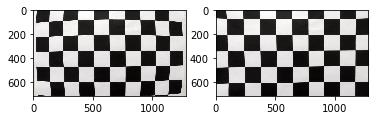

In [228]:
camera.calibrateCamera(chessboard_images)
idx=0
img = camera.undistort(chessboard_images.getChessboardImg(idx))
plt.subplot(121).imshow(chessboard_images.getChessboardImg(idx))
plt.subplot(122).imshow(img)

logging.shutdown()

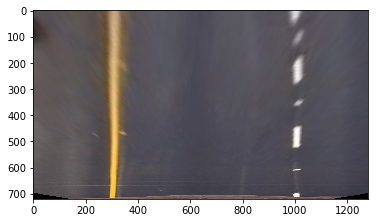

In [229]:
baseline_image = BaselineImage()
camera.updateM(baseline_image.src_points, baseline_image.dst_points)
warped = camera.warpPerspective(camera.baseline_image.img)
plt.imshow(warped)

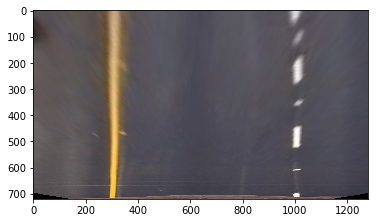

In [230]:
curved_img = mpimg.imread('test_images/straight_lines1.jpg')
warped = camera.warpPerspective(curved_img)
plt.imshow(warped)

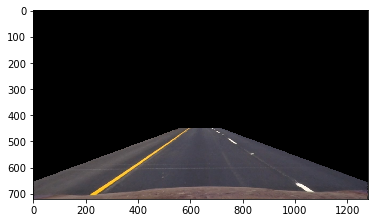

In [231]:
unwarped = camera.unwarpPerspective(warped)
plt.imshow(unwarped)

Gradient and Colorspace

In [63]:
'''
    def h_channel (self, img, t_min=18, t_max=50):
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        h_channel = hls[:,:,0]
        
        mask = np.zeros_like(h_channel)
        mask[(t_min <= h_channel) & (h_channel <= t_max)] = 1
        
        return mask
    
    
    #--- we reuse the test_highlight_yellow_and_white above
    def yellow_white(self, img):

        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

        mask_yellow = cv2.inRange(hsv, yellow_range[0], yellow_range[1])
        mask_white  = cv2.inRange(hsv, white_range[0], white_range[1])

        mask = mask_yellow + mask_white

        return mask
yellow_range = [np.array([20,  70,   0]), 
                np.array([40, 255, 255])]

white_range  = [np.array([  0,  0, 180]), 
                np.array([179, 25, 255])]

        

'''


class LaneEdgeMasker:
    def __init__(self):
        
        return
    
    def Sobel_x(self, img, t_min=20, t_max=255):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, dx=1, dy=0))
        sobel_scaled = np.uint8(255 * sobel / np.max(sobel))
        
        mask = np.zeros_like(sobel_scaled)
        mask[(t_min <= sobel_scaled) & (sobel_scaled <= t_max)] = 1
        
        return mask
    
    def s_channel (self, img, t_min=125, t_max=255):
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        s_channel = hls[:,:,2]
        
        mask = np.zeros_like(s_channel)
        mask[(t_min <= s_channel) & (s_channel <= t_max)] = 1
        
        return mask
    
masker = LaneEdgeMasker()



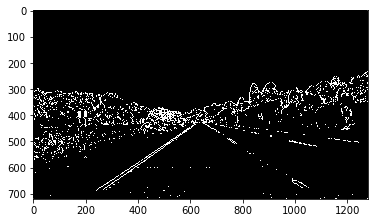

In [232]:
x_mask = masker.Sobel_x(curved_img)
plt.imshow(x_mask, cmap='gray')

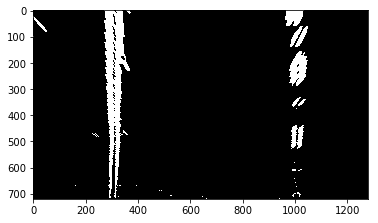

In [233]:
x_warped = camera.warpPerspective(x_mask)
plt.imshow(x_warped, cmap='gray')

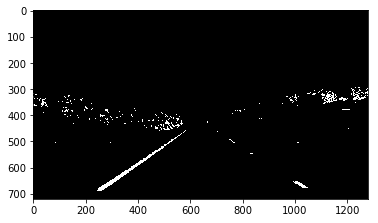

In [234]:
s_mask = masker.s_channel(curved_img)
plt.imshow(s_mask, cmap='gray')

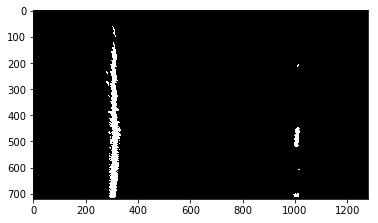

In [235]:
s_warped = camera.warpPerspective(s_mask)
plt.imshow(s_warped, cmap='gray')

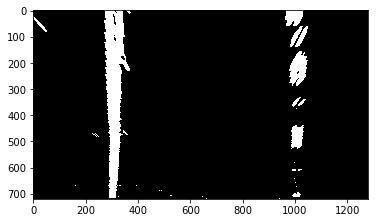

In [236]:
all_mask = s_warped | x_warped
plt.imshow(all_mask, cmap='gray')

Finding the lines

(1280,)


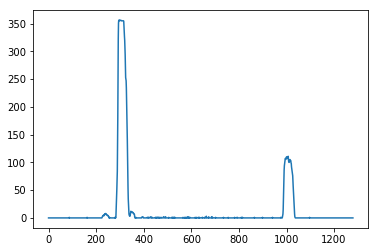

In [237]:
def hist(mask):
    
    bottom_half = mask[mask.shape[0] // 2:,:]
    hist = np.sum(bottom_half, axis=0)
    
    return hist

h = hist(all_mask)
plt.plot(h)
print (h.shape)
    
    

get starting points

In [70]:
mid_x = h.shape[0] //2

left_x_mid = np.argmax(h[:mid_x])
right_x_mid = mid_x + np.argmax(h[mid_x:])
print (left_x_mid, right_x_mid)
print (h[left_x_mid], h[right_x_mid])

295 1007
356 111


In [124]:
class OldSlidingWindow:
    
    def __init__(self, x_mid, target_ht, image_points, 
                 num_segments = 8, x_offset=100, numpoints_found_thresh = 50):

        #--- x1 = x_mid - offset, x2 = x_mid + offset
        self.x_mid    = x_mid
        self.x_offset = x_offset
        self.x1       = x_mid - x_offset
        self.x2       = x_mid + x_offset
        
        self.ht = target_ht // num_segments
        self.y2 = target_ht   #--- y2 is bottom of image
        self.y1 = self.y2 - self.ht
        
        #--- number of points found to calculate
        #--- average x for next mid point when window slides up
        self.numpoints_found_thresh = numpoints_found_thresh
        
        #--- unpack image points which are all the nonzero points in target image
        #--- point (image_points_x[i], image_points_y[i]) is a nonzero point in target image
        self.image_points_x, self.image_points_y = image_points
        
        #--- true if window has slid passed the top of the target image
        self.passed_top = False
        
        #--- holds all image points found in current window using find_points
        self.lane_points_x = []
        self.lane_points_y = []
        
        #--- holds coordinates of windows borders as it is slid up
        #--- used for demo
        self.window_history = []
        
        return
    
    
    def findPoints(self):
        '''
        Finds points in image_points that are in window.
        
        - Accumulates points found in lane_points
        - Call slideUp() after findPoints, otherwise, duplicate points may be collected
        - mid_x updated to average of x points found
        '''
        
        while not self.passed_top:        
            
            self.window_history.append([self.x1, self.y1, self.x2, self.y2])
            
            #--- mask in all points within window by x and y values
            x_bool_mask = (self.x1 <= self.image_points_x) & (self.image_points_x <= self.x2)
            y_bool_mask = (self.y1 <= self.image_points_y) & (self.image_points_y <= self.y2)

            #--- bit wise the x and y masks to get the actual points
            xy_bool_mask = (x_bool_mask) & (y_bool_mask)

            #--- apply mask to image_points_x and _y to find the points that are in window region
            points_found_x = self.image_points_x[xy_bool_mask]
            points_found_y = self.image_points_y[xy_bool_mask]

            #--- collect the points found into lane_points_x and _y
            #--- if window is not slid up after call to findpoints, 
            #--- then lane_points may contain duplicate points on next call to findpoints
            self.lane_points_x.extend(points_found_x)
            self.lane_points_y.extend(points_found_y)

            #--- update the midpoint if enough points found above threshold
            if len(points_found_x) >= self.numpoints_found_thresh:
                #--- must be INT! or 
                self.x_mid = np.int(np.average(points_found_x))
                
            self.slideUp()
        
        return 
    
    
    def slideUp (self):
        '''
        Updates window position by decreasing y1 and y2
        
        - y2 updated first to one line above y1
        - y1 is then updated to y2 - height of window
        - if y2 <= 0, then window has reached the top
        - x1 and x2 are updated in case find_points updated xmid
        '''
        
        #--- update y2 (bottom) of window to line above top
        self.y2 = self.y1 - 1
        
        if self.y2 > 0:
            self.y1 = self.y1 - self.ht - 1
            if self.y1 < 0:
                #--- set y1 to 0 if y1 is below 0
                self.y1 = 0

            self.x1 = self.x_mid - self.x_offset
            self.x2 = self.x_mid + self.x_offset

        else:
            self.passed_top = True
            
        return
    
    
class LineWindow:
    
    def __init__ (self, line, target_ht, image_points, x_offset=100):
        
        self.line = line
        self.ht = target_ht
        self.image_points_x, self.image_points_y = image_points
        
        self.x1 = line.X(self.image_points_y) - x_offset
        self.x2 = self.x1 + x_offset + x_offset
        
        self.lane_points_x = []
        self.lane_points_y = []
        
        return
    
    
    def findPoints (self):
        
        #--- mask in all points within window by x values
        x_bool_mask = (self.x1 <= self.image_points_x) & (self.image_points_x <= self.x2)
        
        #--- apply mask to image_points_x and _y to find the points that are in window region
        points_found_x = self.image_points_x[x_bool_mask]
        points_found_y = self.image_points_y[x_bool_mask]
        
        #--- collect the points found into lane_points_x and _y
        #--- if window is not slid up after call to findpoints, 
        #--- then lane_points may contain duplicate points on next call to findpoints
        self.lane_points_x.extend(points_found_x)
        self.lane_points_y.extend(points_found_y)
        
        return
        


class OldLine:
    
    def __init__(self, x, y, polyfit_tries = 10):
        
        self.logger = logging.getLogger("Line")
        
        #--- needed to use error handling for calls to polyfit
        #--- would cause "SVD" did not converge error in jupyter notebook every other run
        #--- polyfit will likely succeed on second try
        #--- discussion: https://github.com/numpy/numpy/issues/16744 says its due to windows
        
        tries = 0
        while True:
            try:
                tries += 1
                #--- we solve for X!!! i.e. x = ay**2 + by + C
                fit = np.polyfit(y, x, deg=2)
                if tries > 1:
                    msg = "Polyfit succeeded on try {}."
                    self.logger.warning(msg.format(tries))
                break
            except Exception as e:
                if tries < polyfit_tries:
                    msg = "Polyfit failed: {}. Trying again."
                    self.logger.warning(msg.format(e))
                    continue
                else:
                    msg = "Polyfit failed. {}."
                    self.logger.error(msg)
                    
        '''
        fit = np.polyfit(y, x, deg=2)
        
        '''
                
        self.a = fit[0]   # coeff for y**2
        self.b = fit[1]   # coeff for y
        self.c = fit[2]   # constant
        
        return
    
    
    def generatePoints(self, img_ht):
        '''
        Generates the x and y coordinates of the line along the height of the image.
        '''
        
        #--- generate y points from 0 to img_ht - 1
        y_line_points = np.array([float(y) for y in range(img_ht)])
                                 
        #--- calculate points based on x
        x_line_points = self.X(y_line_points)
        
        return x_line_points, y_line_points
    
    
    def X(self, y):
        '''
        Generates x-coordinates given y-coordinates
        '''
        
        x = self.a * y**2 + self.b * y + self.c
        
        return x
        
        
class LineGenerator:
    
    def __init__(self, lane_warped_img_binary):
        
        self.img_binary   = lane_warped_img_binary
        
        
    def findStartingX(self):
        
        y_mid = self.img_binary.shape[0] // 2
        img_binary_bottom_half = self.img_binary[y_mid:, :]
        
        hist    = np.sum(img_binary_bottom_half, axis=0)
        x_mid   = self.img_binary.shape[1] // 2
        
        self.x_start_left  = np.argmax(hist[:x_mid])
        self.x_start_right = np.argmax(hist[x_mid:]) + x_mid
        
        return
    
    
    def findImagePoints(self):
        
        nonzero_points = np.nonzero(self.img_binary)
        
        #--- y (row) points come first!!! index 0
        #--- x (col) points are in second!!! index 1
        self.image_points_y = np.array(nonzero_points[0])
        self.image_points_x = np.array(nonzero_points[1])
        
        self.image_points = (self.image_points_x, self.image_points_y)
        
        return 
        
        
    def findLinesDemo(self):
        
        demo_img = np.dstack((self.img_binary * 255, self.img_binary * 255, self.img_binary * 255))
        
        self.findStartingX()
        self.findImagePoints()
        
        left_window     = SlidingWindow(self.x_start_left,  self.img_binary.shape[0], self.image_points)
        right_window    = SlidingWindow(self.x_start_right, self.img_binary.shape[0], self.image_points)

        lines_found  = []
        windows      = [left_window, right_window]
        point_colors = [[255, 0, 0], [0, 0, 255]]
        for window, point_color in zip(windows, point_colors):
            
            window.findPoints()
                    
            if window.lane_points_x:
                #--- create the line based on the lane points found
                line = Line(window.lane_points_x, window.lane_points_y)
                lines_found.append(line)
                demo_img[window.lane_points_y, window.lane_points_x] = point_color

        plt.figure(figsize=(11, 6.5))
        for line in lines_found:
            x_line_points, y_line_points = line.generatePoints(self.img_binary.shape[0])
            plt.plot(x_line_points, y_line_points, color='yellow')
        plt.imshow(demo_img)
        
        return lines_found
    
    
    def findLines(self):
        
        self.findStartingX()
        self.findImagePoints()
        
        left_window  = SlidingWindow(self.x_start_left,  self.img_binary.shape[0], self.image_points)
        right_window = SlidingWindow(self.x_start_right, self.img_binary.shape[0], self.image_points)

        self.lines_found  = []
        windows      = [left_window, right_window]
        for window in windows:
            
            window.findPoints()
                    
            if window.lane_points_x:
                #--- create the line based on the lane points found
                line = Line(np.array(window.lane_points_x), np.array(window.lane_points_y))
                self.lines_found.append(line)

        return self.lines_found
    
    
    def findLinesLineWindow(self):
        
        demo_img = np.dstack((self.img_binary * 255, self.img_binary * 255, self.img_binary * 255))
        
        line_windows = []
        for line in self.lines_found:
            line_window = LineWindow(line, self.img_binary.shape[0], self.image_points)
            line_windows.append(line_window)

        self.lines_found = []
        for line_window in line_windows:
            line_window.findPoints()
            
            if line_window.lane_points_x:
                #--- create the line based on the lane points found
                line = Line(line_window.lane_points_x, line_window.lane_points_y)
                self.lines_found.append(line)
            
        plt.figure(figsize=(11, 6.5))
        for line in self.lines_found:
            x_line_points, y_line_points = line.generatePoints(self.img_binary.shape[0])
            plt.plot(x_line_points, y_line_points, color='yellow')
        plt.imshow(demo_img)
        
        return
        
        
            
lineGenerator = LineGenerator(all_mask)       


In [125]:
lines = lineGenerator.findLines()
print (lines[0].a)

-1.9304906075118617e-05


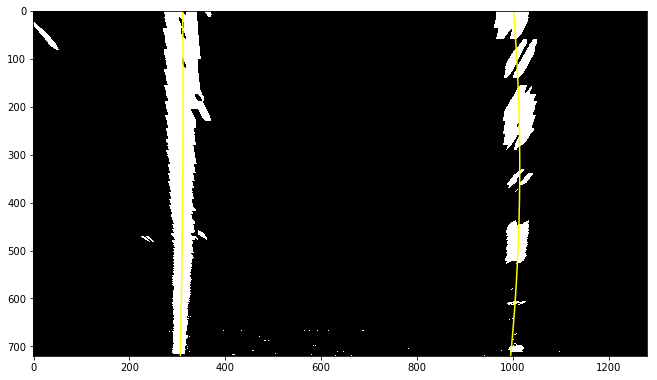

In [126]:
lines = lineGenerator.findLinesLineWindow()

In [107]:
x = np.array([34, 35, 12 , 45, 56])
y = np.array([432, 123, 40 , 125, 456])
m = (12 <= x) & (x <= 35)
n = (430 <= y) & (y <= 435)
print (m)
print (n)
x_points = x[m & n]
y_points = y[m & n]
print (np.stack((x_points, y_points)))

[ True  True  True False False]
[ True False False False False]
[[ 34]
 [432]]


In [393]:
class SlidingWindow:
    
    def __init__(self, x_mid, target_ht, image_points, 
                 num_segments = 8, x_offset=100, numpoints_found_thresh = 50):

        #--- x1 = x_mid - offset, x2 = x_mid + offset
        self.x_mid    = x_mid
        self.x_offset = x_offset
        self.x1       = x_mid - x_offset
        self.x2       = x_mid + x_offset
        
        self.ht = target_ht // num_segments
        self.y2 = target_ht   #--- y2 is bottom of image
        self.y1 = self.y2 - self.ht
        
        #--- number of points found to calculate
        #--- average x for next mid point when window slides up
        self.numpoints_found_thresh = numpoints_found_thresh
        
        #--- unpack image points which are all the nonzero points in target image
        #--- point (image_points_x[i], image_points_y[i]) is a nonzero point in target image
        self.image_points_x, self.image_points_y = image_points
        
        #--- true if window has slid passed the top of the target image
        self.passed_top = False
        
        #--- holds all image points found in current window using find_points
        self.lane_points_x = []
        self.lane_points_y = []
        
        #--- holds coordinates of windows borders as it is slid up
        #--- used for demo
        self.window_history = []
        
        return
    
    
    def reinit (self, x_mid, target_ht, image_points, 
                 num_segments = 8, x_offset=100, numpoints_found_thresh = 50):
        
        self.__init__(x_mid, target_ht, image_points, 
                 num_segments, x_offset, numpoints_found_thresh)
        return
        
    
    
    def findPoints(self):
        '''
        Finds points in image_points that are in window.
        
        - Accumulates points found in lane_points
        - Call slideUp() after findPoints, otherwise, duplicate points may be collected
        - mid_x updated to average of x points found
        '''
        
        while not self.passed_top:        
            
            self.window_history.append([self.x1, self.y1, self.x2, self.y2])
            
            #--- mask in all points within window by x and y values
            x_bool_mask = (self.x1 <= self.image_points_x) & (self.image_points_x <= self.x2)
            y_bool_mask = (self.y1 <= self.image_points_y) & (self.image_points_y <= self.y2)

            #--- bit wise the x and y masks to get the actual points
            xy_bool_mask = (x_bool_mask) & (y_bool_mask)

            #--- apply mask to image_points_x and _y to find the points that are in window region
            points_found_x = self.image_points_x[xy_bool_mask]
            points_found_y = self.image_points_y[xy_bool_mask]

            #--- collect the points found into lane_points_x and _y
            #--- if window is not slid up after call to findpoints, 
            #--- then lane_points may contain duplicate points on next call to findpoints
            self.lane_points_x.extend(points_found_x)
            self.lane_points_y.extend(points_found_y)

            #--- update the midpoint if enough points found above threshold
            if len(points_found_x) >= self.numpoints_found_thresh:
                #--- must be INT! or 
                self.x_mid = np.int(np.average(points_found_x))
                
            self.slideUp()
        
        return (self.lane_points_x, self.lane_points_y)
    
    
    def slideUp (self):
        '''
        Updates window position by decreasing y1 and y2
        
        - y2 updated first to one line above y1
        - y1 is then updated to y2 - height of window
        - if y2 <= 0, then window has reached the top
        - x1 and x2 are updated in case find_points updated xmid
        '''
        
        #--- update y2 (bottom) of window to line above top
        self.y2 = self.y1 - 1
        
        if self.y2 > 0:
            self.y1 = self.y1 - self.ht - 1
            if self.y1 < 0:
                #--- set y1 to 0 if y1 is below 0
                self.y1 = 0

            self.x1 = self.x_mid - self.x_offset
            self.x2 = self.x_mid + self.x_offset

        else:
            self.passed_top = True
            
        return
    
    
class LinearWindow:
    
    def __init__ (self, line, target_ht, image_points, x_offset=100):
        
        self.line = line
        self.ht = target_ht
        self.image_points_x, self.image_points_y = image_points
        
        self.x1 = line.X(self.image_points_y) - x_offset
        self.x2 = self.x1 + x_offset + x_offset
        
        self.lane_points_x = []
        self.lane_points_y = []
        
        return
    
    
    def reinit (self, line, target_ht, image_points, x_offset=100):
        
        self.__init__(self, line, target_ht, image_points, x_offset)
        
        return

    
    
    def findPoints (self):
        
        #--- mask in all points within window by x values
        x_bool_mask = (self.x1 <= self.image_points_x) & (self.image_points_x <= self.x2)
        
        #--- apply mask to image_points_x and _y to find the points that are in window region
        points_found_x = self.image_points_x[x_bool_mask]
        points_found_y = self.image_points_y[x_bool_mask]
        
        #--- collect the points found into lane_points_x and _y
        #--- if window is not slid up after call to findpoints, 
        #--- then lane_points may contain duplicate points on next call to findpoints
        self.lane_points_x.extend(points_found_x)
        self.lane_points_y.extend(points_found_y)
        
        return self.lane_points_x, self.lane_points_y
    

class Line:
    '''
    descritpion


    '''
    
    def __init__(self, x, y, polyfit_tries = 10):
        
        self.logger = logging.getLogger("Line")
        
        #--- needed to use error handling for calls to polyfit
        #--- would cause "SVD" did not converge error in jupyter notebook every other run
        #--- polyfit will likely succeed on second try
        #--- discussion: https://github.com/numpy/numpy/issues/16744 says its due to windows
        
        tries = 0
        while True:
            try:
                tries += 1
                #--- we solve for X!!! i.e. x = ay**2 + by + C
                fit = np.polyfit(y, x, deg=2)
                if tries > 1:
                    msg = "Polyfit succeeded on try {}."
                    self.logger.warning(msg.format(tries))
                break
            except Exception as e:
                if tries < polyfit_tries:
                    msg = "Polyfit failed: {}. Trying again."
                    self.logger.warning(msg.format(e))
                    continue
                else:
                    msg = "Polyfit failed. {}."
                    self.logger.error(msg)
                    
        '''
        fit = np.polyfit(y, x, deg=2)
        
        '''
                
        self.a = fit[0]   # coeff for y**2
        self.b = fit[1]   # coeff for y
        self.c = fit[2]   # constant
        
        return
    
    
    def generatePoints(self, img_ht):
        '''
        Generates the x and y coordinates of the line along the height of the image.
        
        parameters:
        - img_ht: height of image
        
        returns:
        - x_points: array of the x coordinates of the line in int32
        - y_points: array of y coordinates of the line in int32
        '''
        
        #--- generate y points from 0 to img_ht - 1, cast to int32 for ease of plotting
        y_line_points = np.int32 (np.array([float(y) for y in range(img_ht)]))
                                 
        #--- calculate points based on x, cast to int32 for ease of plotting
        x_line_points = np.int32 (self.X(y_line_points))
        
        return x_line_points, y_line_points
    
    
    def X(self, y):
        '''
        Generates x-coordinates given y-coordinates
        
        - returns x as
        '''
        
        x = self.a * y**2 + self.b * y + self.c
        
        return x

    
class LaneDetector:
    
    def __init__(self):
        
        self.logger = logging.getLogger("LaneDetector")
        
        self.binary_warped = None
        
        self.x_start       = None
        self.image_points  = None
        self.lane_lines    = []
        
        #--- must be a class that implements findPoints() and returns a Line
        self.lane_points_finder = None
        self.sliding_window = None
        self.linear_window = None
        
        #--- points of the lane line in ([[x1, y1], [x2, y2], ...) format that is used in cv2 drawing functions
        self.paint_points = None
        
        return
    
    def updateXStart(self):
        
        raise NotImplementedError()
        
    def getLaneColor(self):
        '''
        gets color used for painting lane line
        
        - defaults to red
        - change in descendent classes to 
        '''
        
        return [255, 0, 0]
    
    def findImagePoints(self):
        
        nonzero_points = np.nonzero(self.binary_warped)
        
        #--- y (row) points come first!!! index 0
        #--- x (col) points are in second!!! index 1
        image_points_y = np.array(nonzero_points[0])
        image_points_x = np.array(nonzero_points[1])
        
        self.image_points = (image_points_x, image_points_y)
        
        return 
    
    def getSlidingWindow(self):

        self.updateXStart()
        if self.sliding_window:
            #--- resuse existing and reinitizalize instance
            self.sliding_window.reinit(self.x_start,
                                      target_ht    = self.binary_warped.shape[0],
                                      image_points = self.image_points)
        else:
            self.sliding_window = SlidingWindow(self.x_start,
                                               target_ht    = self.binary_warped.shape[0],
                                               image_points = self.image_points)
        
        return self.sliding_window
        
    def getLinearWindow(self):
        last_lane_line = self.lane_lines[-1]
        if self.linear_window:
            #--- reuse and reinitizalize existing instance
            self.linear_window.reinit(last_lane_line, 
                                      target_ht    = self.binary_warped.shape[0],
                                      image_points = self.image_points)
        else:
            self.linear_window = LinearWindow(last_lane_line)
            
        return self.linear_window
        
    def selectLanePointsFinder(self):
        
        if self.lane_lines:
            self.lane_points_finder = self.getLinearWindow()
        else:
            self.lane_points_finder = self.getSlidingWindow()
            
        return
            
    def checkLaneLine(self, line):
        #--- TODO: code this!!!
        pass
    
    def findLaneLine (self, binary_warped):
        
        self.binary_warped = binary_warped
        
        self.findImagePoints()
        self.selectLanePointsFinder()
        
        x_lane_points, y_lane_points = self.lane_points_finder.findPoints()
        
        lane_line = Line(x_lane_points, y_lane_points)
        
        self.checkLaneLine(lane_line)
        self.lane_lines.append(lane_line)
        
        return 
    
    def getPaintPoints(self, canvas, flipud=False):
        '''
        Returns an array of points repesenting the line of the lane
        
        Params:
        - canvas: an RGB image painting area; just needed to get 
        the height of the canvas to generate the set of points
        - flipud: option for returning the array of points in reverse order
        
        Returns:
        - an array of points like [[[x1, y1], [x2, y2], ...]], shape is like (1, numpoints, 2)

        - points are suitable for using in cv2 draw functions
        - if no lanes were found, returns None
        - set flipud (flip unside down) to true; this is useful for flipping an oppposite lane
        to form a polygon for a fillpoly call
        
        '''

        if not self.lane_lines:
            return None

        if self.paint_points is None: 
            curr_lane_line = self.lane_lines[-1]
            x_points, y_points = curr_lane_line.generatePoints(canvas.shape[0])

            #--- combine and transform x_ and y_points to [[x1, y1], [x2, y2], ...]
            self.paint_points = np.array([(np.transpose(np.vstack((x_points, y_points))))])
            
        if flipud:
            #--- if you flipud(paint_points), it will be the same 
            #--- since there is only 1 element in first dimension
            #--- first element of paint_points contains the actual points
            #--- so flipud (paint_points[0]) then apply np.array([])
            return np.array([np.flipud(self.paint_points[0])])
        
        else:
            return self.paint_points
    
    def paint (self, canvas):
        '''
        paints the points of the line
        '''

        cv2.polylines(canvas, 
                      pts       = self.getPaintPoints(canvas), 
                      isClosed  = False, 
                      color     = [255, 0, 0],    #--- default red line color
                      thickness = 20)        
        return
    
        
class LeftLaneDetector(LaneDetector):

    def updateXStart(self):
        
        bottom_half = self.binary_warped[self.binary_warped.shape[0] // 2:,:]
        histogram = np.sum(bottom_half, axis=0)

        mid_x = histogram.shape[0] // 2
        self.x_start = np.argmax(histogram[:mid_x])
        
        return
    
    
class RightLaneDetector(LaneDetector):
    
    def updateXStart(self):
        
        bottom_half = self.binary_warped[self.binary_warped.shape[0] // 2:,:]
        histogram = np.sum(bottom_half, axis=0)

        mid_x = histogram.shape[0] // 2
        self.x_start = mid_x + np.argmax(histogram[mid_x:])
        
        return

# AdvancedLaneDetector

In [394]:
class AdvancedLaneDetector:
    
    def __init__(self):
        
        self.left_lane_detector  = LeftLaneDetector()
        self.right_lane_detector = RightLaneDetector()
        self.left_lane = None
        self.right_lane = None
        return
        
    def findLanes(self, binary_warped):
    
        self.left_lane_detector.findLaneLine(binary_warped)
        self.right_lane_detector.findLaneLine(binary_warped)
        
        return
    
    def paint(self, binary_warped):
        
        #--- create the canvas for painting
        #--- black canvas [0 0 0 ...]
        canvas_binary = np.zeros_like(binary_warped).astype(np.uint8)
        #--- black RGB canvass [[0 0 0], [0 0 0], [0 0 0], ...]
        canvas = np.dstack((canvas_binary, canvas_binary, canvas_binary))
        
        #--- tell left and right lane detectors to paint their portion on canvas
        self.left_lane_detector.paint(canvas)
        self.right_lane_detector.paint(canvas)
        
        #--- get polygon for lane area by using 
        left_lane_paint_points = self.left_lane_detector.getPaintPoints(canvas)
        #--- need to "reverse" right points array so tail of pts_left is next to head of pts_right
        #--- this ordering allows fillpoly to traverse around perimeter, 
        #--- if the order of points is not flipud, the fill will look like a bowtie
        right_lane_paint_points = self.right_lane_detector.getPaintPoints(canvas, flipud=True)
        
        if left_lane_paint_points is not None and right_lane_paint_points is not None:
            #--- combaine paintpoints into a polygon
            lane_area_paint_pts = np.hstack((left_lane_paint_points, right_lane_paint_points))

            #--- paint the lane area
            cv2.fillPoly(canvas, lane_area_paint_pts, [0,255,0])

        return canvas
    
        

In [395]:
ald = AdvancedLaneDetector()
ald.findLanes(all_mask)

WARNING  | Line: Polyfit failed: SVD did not converge in Linear Least Squares. Trying again.
WARNING  | Line: Polyfit succeeded on try 2.


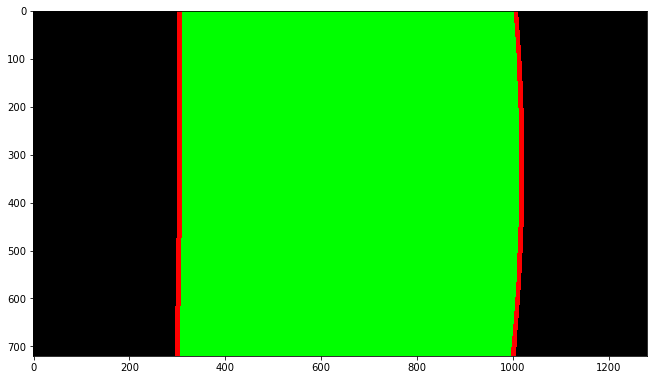

In [396]:
canvas = ald.paint(all_mask)
plt.figure(figsize=(11, 6.5))
plt.imshow(canvas)


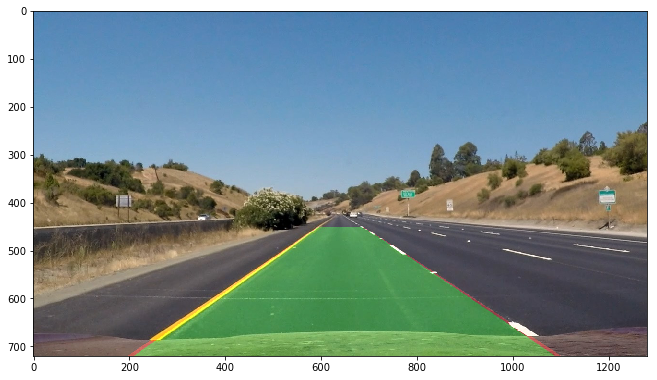

In [397]:
unwarpcanvas = camera.unwarpPerspective(canvas)
result = cv2.addWeighted(curved_img, 1, unwarpcanvas, 0.3, 0)
plt.figure(figsize=(11, 6.5))
plt.imshow(result)

In [242]:
canvas_binary = np.zeros_like(all_mask).astype(np.uint8)
canvas = np.dstack((canvas_binary, canvas_binary, canvas_binary))
canvas.shape

(720, 1280, 3)

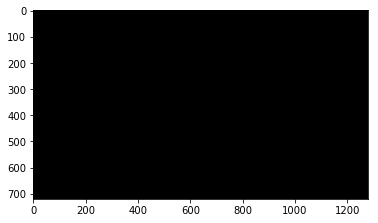

In [243]:
plt.imshow(canvas)

In [244]:
lx_points, ly_points = ald.left_lane.generatePoints(canvas.shape[0])
rx_points, ry_points = ald.right_lane.generatePoints(canvas.shape[0])

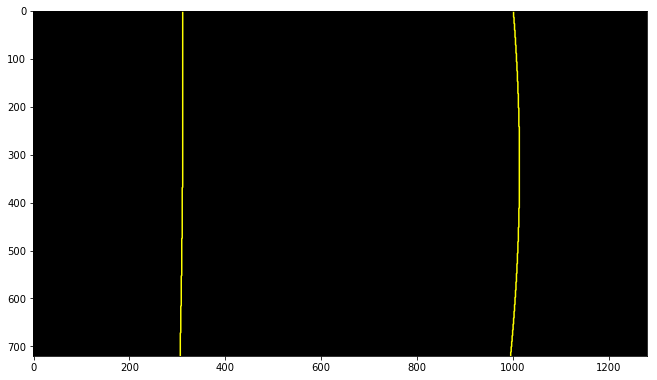

In [245]:
plt.figure(figsize=(11, 6.5))
plt.plot(lx_points, ly_points, color='yellow')
plt.plot(rx_points, ry_points, color='yellow')
plt.imshow(canvas)


(1, 1440, 2)
(720, 1280, 3)


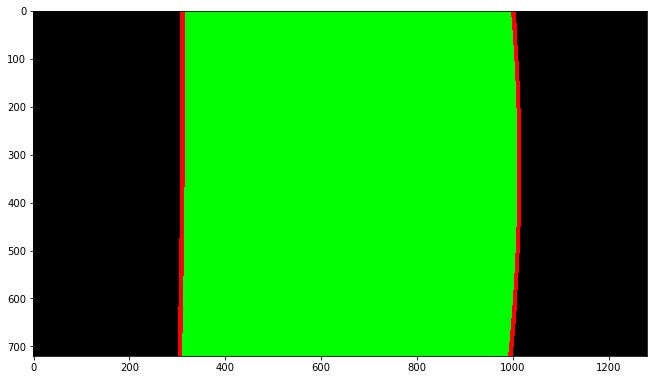

In [252]:
plt.figure(figsize=(11, 6.5))

pts_left = np.array([(np.transpose(np.vstack((lx_points, ly_points))))])
pts_right = np.array([np.flipud(np.transpose(np.vstack((rx_points, ry_points))))])
pts = np.hstack((pts_left, pts_right))
print (pts.shape)

cv2.fillPoly(canvas, np.int_([pts]), [0,255,0])
cv2.polylines(canvas, pts_left, False, [255,0,0], 8)
cv2.polylines(canvas, pts_right, False, [255,0,0], 8)


plt.imshow(canvas)
print (canvas.shape)

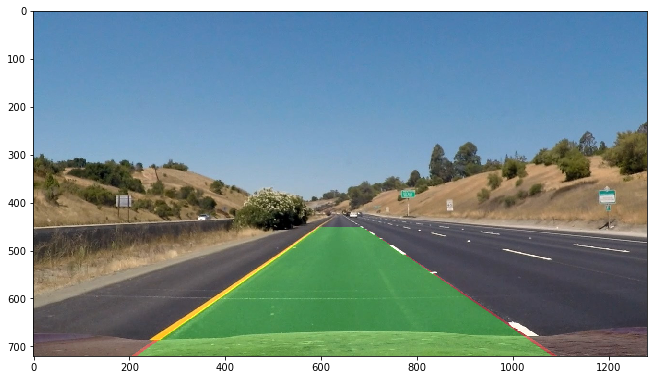

In [254]:
unwarpcanvas = camera.unwarpPerspective(canvas)
result = cv2.addWeighted(curved_img, 1, unwarpcanvas, 0.3, 0)
plt.figure(figsize=(11, 6.5))
plt.imshow(result)

In [377]:
a = np.array([])
if a.size > 0:
    print('not empty')

In [268]:
x = [1, 2, 3, 4, 5]
y = [5, 4, 3, 2, 1]
np.transpose (np.vstack((x,y)))

array([[1, 5],
       [2, 4],
       [3, 3],
       [4, 2],
       [5, 1]])

In [129]:
a = np.array([[1,2,3, 4, 5], [1,2,3, 4, 5], [1,2,3, 4, 5], [1,2,3, 4, 5], [1,2,3, 4, 5]])
s = np.sum(a, axis=0)
print(s.shape)

(5,)


In [170]:
a3 = np.array( [[[10,10],[100,10],[100,100],[10,100]]], dtype=np.int32 )
a3.shape

(1, 4, 2)

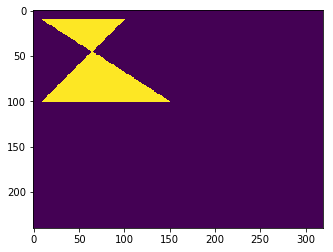

In [190]:
a3 = np.array( [[[10,10],[100,10],[10,100], [150,100]]], dtype=np.int32 )
im = np.zeros([240,320],dtype=np.uint8)
cv2.fillPoly( im, a3, 255 )

plt.imshow(im)
plt.show()

In [89]:
def f(a):
    a = 10
    return a

x = 1
x = f(x)
print(x)

10


In [ ]:
img = mpimg.imread('test_images/straight_lines1.jpg')

ht = img.shape[0] - 1
wid = img.shape[1] - 1
midx = wid // 2
offsetx = 40
top = 425
bottom = ht

#--- XY coords
dx1 = 211
dx2 = 230


'''
source_points = np.float32 ([[592, 451],      [688, 451],     [1123, 719], [191, 719]])
# source_points = np.float32 ([[485, 530],      [805, 530],     [1104, 719], [211, 719]])

dest_points   = np.float32 ([[191, 0],      [1123, 0],     [1123, 719], [211, 719]])
# dest_points =   np.float32 ([[634 - dx1,   0],[644 + dx2, 0], [1104 - dx2, 719], [211 + dx1, 719]])

'''
source_points = np.float32 ([[592, 451],      [688, 451],     [1123, 719], [191, 719]])
# source_points = np.float32 ([[485, 530],      [805, 530],     [1104, 719], [211, 719]])

dest_points   = np.float32 ([[391, 0],      [923, 0],     [923, 719], [391, 719]])
# dest_points =   np.float32 ([[634 - dx1,   0],[644 + dx2, 0], [1104 - dx2, 719], [211 + dx1, 719]])



print (source_points)
print (dest_points)

plt.imshow(img)
for i in range(4):
    plt.plot(source_points[i][0], source_points[i][1], '.')



In [ ]:
M = cv2.getPerspectiveTransform(source_points, dest_points)
warped = cv2.warpPerspective(img, M, (1280, 720), flags=cv2.INTER_LINEAR)
# warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
plt.imshow(warped)

In [ ]:



camera.getPerspectiveTransform(source_points, dest_points)
warped = camera.warpPerspective(img)
plt.imshow(warped)

In [ ]:
ret, corners = cv2.findChessboardCorners(gray, (9, 5), None)
if ret:
    print (corners.shape)

In [ ]:
#--- chessboard dimensions is in X by Y where X is columns, Y is rows

obj_points = np.zeros((9*5, 3), np.float32)
obj_points_2 = np.zeros((9*5, 3), np.float32)

#--- points are on the XY plane, so Z = 0
obj_points[:, :2] = np.mgrid[:9, :5].T.reshape(-1, 2)
obj_points_2[:, :2] = np.array([(x, y) for y in range(5) for x in range (9)])

# np.mgrid[:9, :5].T.reshape(-1, 2)
same = obj_points == obj_points_2
#print (same)
print (obj_points[:5])
print (obj_points_2[:5])

In [ ]:
mgrid = np.mgrid[:9, :5]
print (mgrid.shape)
print (mgrid)

In [ ]:
print (mgrid.T.shape)
print (mgrid.T)

In [ ]:
print (mgrid.T.reshape(-1, 2))
print (mgrid.T.shape)

In [ ]:
coords = mgrid.T.reshape(-1, 2)

In [ ]:
print (coords.shape)
print (corners.shape)
print (corners)

In [ ]:
img = cv2.drawChessboardCorners(img, (9, 5), corners, ret)
plt.imshow(img)

In [ ]:
shape = (4, 5, 3, 2, 8)
shape[2::2]